# Neural Networks: CNN

The work of this notebook is based on the paper from Jain et al. [1][2]. A CNN is trained using semantically enriched vectors (using Word2Vec).


[1] Gauri Jain, Manisha Sharma, and Basant Agarwal. Spam detection on social media using semantic convolutional neural network. *International Journal of Knowledge Discovery inBioinformatics (IJKDB)*, 8(1):12–26, 2018.

[2] Gauri Jain, Manisha Sharma, and Basant Agarwal. Spam detection in social media using convolutional and long short term memory neural network. *Annals of Mathematics andArtificial Intelligence*, 85(1):21–44, 2019

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Dropout, Flatten, Input, LSTM, MaxPooling1D
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [2]:
def plot_metrics(history, validation=False):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(12)
    # Accuracy
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.plot(history['accuracy'])
    if validation:
        ax1.plot(history['val_accuracy'])
    ax1.legend(['Train', 'Validation'], loc='upper left')

    # Loss
    ax2.set_title('Model loss') 
    ax2.set_ylabel('Loss') 
    ax2.set_xlabel('Epoch')
    ax2.plot(history['loss'])
    if validation:
        ax2.plot(history['val_loss'])
    ax2.legend(['Train', 'Validation'], loc='upper left') 

    plt.show()

In [3]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

In [4]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_space(X, y, title):  
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig, elev=20, azim=134)
    
    for l, c, m in zip(np.unique(y), colors, markers):
        ax.scatter(
            X[y==l, 0],
            X[y==l, 0],
            X[y==l, 0],
            c=c, label=l, marker=m, edgecolor='k'
        )

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.dist = 12
    ax.set_title(title)
    ax.legend(loc='upper right')

In [5]:
# Show versions
import platform
import keras
import tensorflow as tf

print(f"Python: {platform.python_version()}")
print(f"Keras: {keras.__version__}")
print(f"Tensorflow: {tf.__version__}")

Python: 3.6.9
Keras: 2.4.3
Tensorflow: 2.3.0


In [6]:
# Connect to GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Data loading and vectorization

In [7]:
# When using Goolge Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
base_path = "/content/drive/My Drive"

In [9]:
full_filepath = f"{base_path}/datasets/zenodo_open_metadata_2020-11-14_balanced_full.jsonl"
full_df = pd.read_json(full_filepath, lines=True)  # The file is JSONLines

In [10]:
full_df.head()

,recid,text,spam
0,1835666,the etiology of acute pleurisy with effusion n a,False
1,3044415,biodiversity taxonomy terrestrial herbarium so...,False
2,2071031,zur kenntniss des olivenls n a,False
3,2825828,science school was burned a case study of cri...,False
4,1683734,the heat of vaporization of air n a,False


In [11]:
# Split dataset
labels = full_df['spam']
cat_labels = to_categorical(labels)
data = full_df["text"]

### Display the distribution in 2D and 3D using PCA

From the paper of Jain et al. the optimal number of features is 5000 for the SMS dataset and 8000 for Twitter's one.

In [13]:
num_features = 5000

In [14]:
# Vectorize the full data for displaying purposes
tfidf = TfidfVectorizer(max_features=num_features, ngram_range=(4, 5), analyzer='word', stop_words='english')

In [15]:
# When using TF-IDF the data_vec needs to be made dense (it is a sparse one), use `.todense()`
data_vec = tfidf.fit_transform(data).todense()

In [16]:
pca_2 = PCA(n_components=2)

# y = labels (no need to assign)
X_2d = pca_2.fit_transform(data_vec)

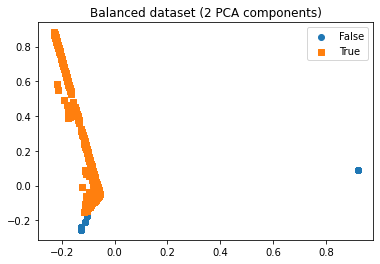

In [17]:
plot_2d_space(X_2d, labels, 'Balanced dataset (2 PCA components)')

In [18]:
pca_3 = PCA(n_components=3)

# y = labels (no need to assign)
X_3d = pca_3.fit_transform(data_vec)

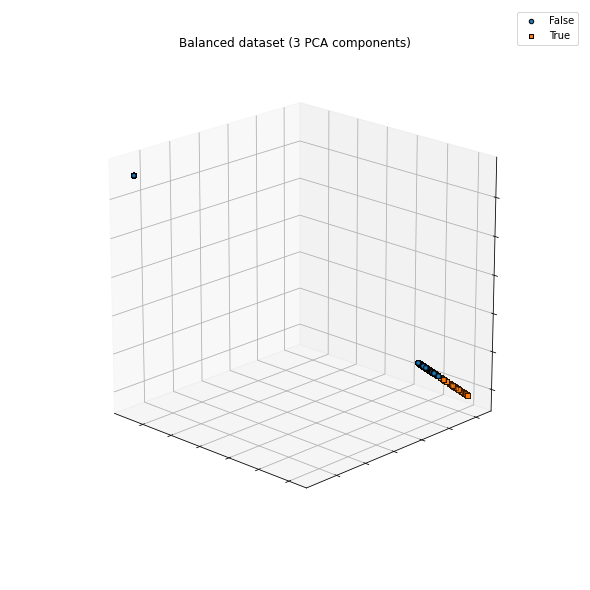

In [19]:
plot_3d_space(X_3d, labels, 'Balanced dataset (3 PCA components)')

### Dataset split and preparation

In [12]:
X_train_orig, X_test_orig, y_train, y_test = train_test_split(data, cat_labels, test_size=0.3, random_state=422)
X_train_orig, X_val_orig, y_train, y_val = train_test_split(X_train_orig, y_train, test_size=0.1, random_state=422)

In [13]:
num_features = 8000

In [14]:
# Vectorize text input
tfidf = TfidfVectorizer(max_features=num_features, ngram_range=(4, 5), analyzer='word', stop_words='english')

In [15]:
X_train_vec = tfidf.fit_transform(X_train_orig).todense()
X_val_vec = tfidf.fit_transform(X_val_orig).todense()
X_test_vec = tfidf.transform(X_test_orig).todense()

In [16]:
print(f"Original training set shape {X_train_vec.shape}")
print(f"Original validation set shape {X_val_vec.shape}")
print(f"Original test set shape {X_test_vec.shape}")

Original training set shape (47607, 8000)
Original validation set shape (5290, 8000)
Original test set shape (22671, 8000)


In [17]:
X_train = np.asarray(X_train_vec).reshape((len(X_train_vec), num_features, 1))
X_val = np.asarray(X_val_vec).reshape(len(X_val_vec), num_features, 1)
X_test = np.asarray(X_test_vec).reshape(len(X_test_vec), num_features, 1)

In [18]:
print(f"Training set shape {X_train.shape}")
print(f"Validation set shape {X_val.shape}")
print(f"Test set shape {X_test.shape}")

Training set shape (47607, 8000, 1)
Validation set shape (5290, 8000, 1)
Test set shape (22671, 8000, 1)


In [19]:
num_classes = 2  # Number of target classes (Spam and Ham)

In [20]:
print(f"Training labels set size {y_train.shape}")
print(f"Validation labels set size {y_val.shape}")
print(f"Test labels set size {y_test.shape}")

Training labels set size (47607, 2)
Validation labels set size (5290, 2)
Test labels set size (22671, 2)


## CNN

From the paper of Jain et al. the hyperparameters are:

| | SMS | Twitter |
|:-|:-:|:-:|
| Num features | 5000| 8000 |
| Number of filters | 128 | 54 |
| Filter length | 5 | 4 |
| Droput | 0.1 | 0.2 |
| Optimizer | Adagrad (lr: 0.1) | Adagrad (lr: 0.1) |
| Activation function | ReLu | ReLu |
| Epochs | 10 | 10 |


In [21]:
with tf.device('/device:GPU:0'):
  cnn_model = Sequential()

  cnn_model.add(Conv1D(filters=54, kernel_size=4, input_shape=(num_features, 1), activation="relu"))
  cnn_model.add(MaxPooling1D())
  cnn_model.add(Dropout(rate=0.2))
  cnn_model.add(Flatten())
  cnn_model.add(Dense(units=num_classes, activation="softmax"))

  cnn_model.compile(optimizer="adagrad", loss='categorical_crossentropy', metrics=['accuracy'])

  cnn_history = cnn_model.fit(
      X_train,
      y_train,
      epochs=10,
      validation_data=(X_val, y_val)
  )

Epoch 1/10
1488/1488 [==============================] - 20s 14ms/step - loss: 0.6682 - accuracy: 0.6831 - val_loss: 0.6763 - val_accuracy: 0.5193
Epoch 2/10
1488/1488 [==============================] - 20s 13ms/step - loss: 0.6154 - accuracy: 0.7818 - val_loss: 0.6540 - val_accuracy: 0.7896
Epoch 3/10
1488/1488 [==============================] - 20s 13ms/step - loss: 0.5607 - accuracy: 0.8337 - val_loss: 0.6302 - val_accuracy: 0.8002
Epoch 4/10
1488/1488 [==============================] - 20s 13ms/step - loss: 0.5139 - accuracy: 0.8530 - val_loss: 0.6096 - val_accuracy: 0.8091
Epoch 5/10
1488/1488 [==============================] - 20s 13ms/step - loss: 0.4774 - accuracy: 0.8501 - val_loss: 0.5911 - val_accuracy: 0.7705
Epoch 6/10
1488/1488 [==============================] - 20s 14ms/step - loss: 0.4495 - accuracy: 0.8489 - val_loss: 0.5786 - val_accuracy: 0.8072
Epoch 7/10
1488/1488 [==============================] - 20s 14ms/step - loss: 0.4276 - accuracy: 0.8515 - val_loss: 0.5660 -

In [22]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 7997, 54)          270       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3998, 54)          0         
_________________________________________________________________
dropout (Dropout)            (None, 3998, 54)          0         
_________________________________________________________________
flatten (Flatten)            (None, 215892)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 431786    
Total params: 432,056
Trainable params: 432,056
Non-trainable params: 0
_________________________________________________________________


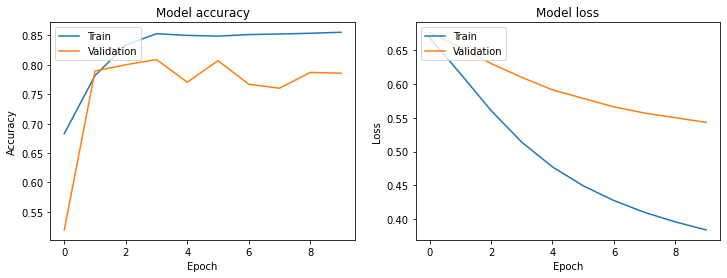

In [23]:
plot_metrics(cnn_history.history, validation=True)

In [24]:
# Save model
models_path = f"{base_path}/models/"
cnn_model.save(f"{models_path}/2020_11_21_paper_twitter_cnn_tfidf_full")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/models//2020_11_21_paper_twitter_cnn_tfidf_full/assets


In [25]:
cnn_y_train_predclass = cnn_model.predict(X_train)

sl_cnn_y_train_predclass = np.argmax(cnn_y_train_predclass, axis=1)
sl_y_train = np.argmax(y_train, axis=1)

cnn_train_accuracy = round(accuracy_score(sl_y_train, sl_cnn_y_train_predclass), 3)
print(f"Train accuracy: {cnn_train_accuracy}")

print("Train Classification Report")
print(classification_report(sl_y_train, sl_cnn_y_train_predclass))

Train accuracy: 0.858
Train Classification Report
              precision    recall  f1-score   support

           0       0.78      1.00      0.87     23694
           1       1.00      0.72      0.83     23913

    accuracy                           0.86     47607
   macro avg       0.89      0.86      0.85     47607
weighted avg       0.89      0.86      0.85     47607



In [26]:
cnn_y_test_predclass = cnn_model.predict(X_test)

sl_cnn_y_test_predclass = np.argmax(cnn_y_test_predclass, axis=1)
sl_y_test = np.argmax(y_test, axis=1)

cnn_test_accuracy = round(accuracy_score(sl_y_test, sl_cnn_y_test_predclass), 3)
print(f"Test accuracy: {cnn_test_accuracy}")

print("Test Classification Report")
print (classification_report(sl_y_test, sl_cnn_y_test_predclass))

Test accuracy: 0.792
Test Classification Report
              precision    recall  f1-score   support

           0       0.71      1.00      0.83     11448
           1       1.00      0.58      0.73     11223

    accuracy                           0.79     22671
   macro avg       0.85      0.79      0.78     22671
weighted avg       0.85      0.79      0.78     22671



### Results

Configuration specific to this problem:
- Batch size: 32 (default)

**SMS configuration** (/models//2020_11_21_paper_sms_cnn_tfidf_4k)

- Time per epoch: ~27s
- 10th epoch accuracy: 0.8445
- 10th epoch validation accuracty: 0.7841
- Train set accuracy: 0.848
- Test set accuracy: 0.79

Train set report:

|  |Precission|Recall|F1 Score|Support|
|:-|:-:|:-:|:-:|:-:|
|0|0.77|1.00|0.87|23694|
|1|1.00|0.70|0.82|23913|
||||||
|accuracy|||0.85|47607|
|macro avg|0.88|0.85|0.84|47607|
|weighted avg|0.88|0.85|0.84|47607|

Test set report:

|  |Precission|Recall|F1 Score|Support|
|:-|:-:|:-:|:-:|:-:|
|0|0.71|1.00|0.83|11448|
|1|1.00|0.58|0.73|11223|
||||||
|accuracy|||0.79|22671|
|macro avg|0.85|0.79|0.78|22671|
|weighted avg|0.85|0.79|0.78|22671|


**Twitter configuration** (/models//2020_11_21_paper_twitter_cnn_tfidf_4k)

- Time per epoch: ~20s
- 10th epoch accuracy: 0.8555
- 10th epoch validation accuracty: 0.7858
- Train set accuracy: 0.853
- Test set accuracy: 0.784

Train set report:

|  |Precission|Recall|F1 Score|Support|
|:-|:-:|:-:|:-:|:-:|
|0|0.78|1.00|0.87|23694|
|1|1.00|0.72|0.83|23913|
||||||
|accuracy|||0.86|47607|
|macro avg|0.89|0.86|0.85|47607|
|weighted avg|0.89|0.86|0.85|47607|

Test set report:

|  |Precission|Recall|F1 Score|Support|
|:-|:-:|:-:|:-:|:-:|
|0|0.71|1.00|0.83|11448|
|1|1.00|0.58|0.73|11223|
||||||
|accuracy|||0.79|22671|
|macro avg|0.85|0.79|0.78|22671|
|weighted avg|0.85|0.79|0.78|22671|